In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import scipy

import math
from livelossplot import PlotLosses

from sklearn.metrics import roc_curve, auc


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


In [54]:
DEBUG_VALUE = 0

In [2]:
train_df = pd.read_csv('./dataset/cleaned_train_5.csv', 
                 header = 0, 
                 names = ['user', 'movie','rating'], 
                 usecols = [0,1,2])

test_df = pd.read_csv('./dataset/cleaned_test_5.csv', 
                 header = 0, 
                 names = ['user', 'movie','rating'], 
                 usecols = [0,1,2])

In [235]:
def prepro(df,user_list=[]):
    df[['rating']]=df[['rating']].astype(float)
    df[['user']]=df[['user']].astype(int)
    df[['movie']]=df[['movie']].astype(int)
    user_id = []
    item_id = []

    if len(user_list) !=0:
                subset = df.merge(user_list,"left",on = "user")[['user_id', 'movie', 'rating']]
    else: 
        user_id = df[['user']].drop_duplicates().reset_index(drop=True).reset_index()
        item_id = df[['movie']].drop_duplicates()
        user_id.rename(columns={'index':'user_id'},inplace=True)
        subset = df.merge(user_id,"left",on = "user")[['user_id', 'movie', 'rating']]

    total_ratings = np.array(subset.values)
    user_item_pairs = total_ratings[:,0:2]
    ratings = total_ratings[:,2:3]
    
    if len(user_list) !=0:
        print("111")
        return total_ratings,user_item_pairs,ratings
    else:
        print("subset")
        num_users = int(len(user_id))
    #     num_users = int(user_id['user'].max() - user_id['user'].min() + 1)
        num_items = len(item_id['movie'])
        print("num_users: ",num_users,"num_items: ", num_items)
        return total_ratings,user_item_pairs,ratings,num_users,num_items,user_id

        

In [29]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, user_item_pairs, ratings):
        'Initialization'
        self.labels  = ratings
        self.samples = user_item_pairs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

    def __getitem__(self, index):
        'Generates one sample of data'
        # # Load data and get label
        #print("called get item")
        user_item_pair = self.samples[index].astype('long')
        user_social = np.zeros(64).astype('long') #convert to actual social embeddings later
        user_item_pair_social = np.concatenate((user_item_pair, user_social), axis=None)
        X = user_item_pair_social
        y = self.labels[index]
        return X, y

In [154]:
class MF(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim,sparse=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim,sparse=True)
        
    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        return (user_embedding*item_embedding).sum(1)


In [31]:
class MLP(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,layers = [16,32,16,8]):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
#         print("item_embedding")
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
#         print("vector",vector)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        out = self.affine_output(vector)
#         rating = self.logistic(logits)
        return out


In [32]:
def predict(model, generator):
    model.eval()
    y_preds_all = torch.Tensor().to(device) 
    y_labels_all = torch.Tensor().to(device) 
    for local_batch, local_labels in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        with torch.no_grad():
            y_preds = model(local_batch[:,0], local_batch[:,1])
        y_preds_all = torch.cat((y_preds_all,y_preds))
        y_labels_all = torch.cat((y_labels_all,local_labels))
    return y_preds_all, y_labels_all
def evaluate(model, generator):
    y_preds_all, y_labels_all = predict(model, generator)  
    y_preds = list(y_preds_all.view(1, y_preds_all.size()[0]).to("cpu").numpy()[0])
    y_actuals = list(y_labels_all.view(1, y_labels_all.size()[0]).to("cpu").numpy()[0])
    print(np.array([y_preds,y_actuals]))
    #print(type(y_preds), type(y_actuals))
    tmse = sum([(a-b) * (a-b) for a,b in zip(y_preds, y_actuals)])
    rmse = math.sqrt((1.0*tmse)/len(y_preds))
    return rmse

In [189]:
BATCH_SIZE = 1024
EPOCH = 10
training_params = {'batch_size': BATCH_SIZE,'shuffle': True,'num_workers': 0}

In [236]:
# make data
total_ratings,user_item_pairs,ratings,num_users,num_items,user_lists = prepro(train_df)
train_dataset = Dataset(user_item_pairs,ratings)

total_ratings_test,user_item_pairs_test,ratings_test = prepro(test_df,user_lists)
test_dataset = Dataset(user_item_pairs_test,ratings_test)

subset
num_users:  70268 num_items:  4499
111


In [237]:
print(total_ratings_test.min())
print(total_ratings_test.min())

nan
nan


In [191]:
train_generator = torch.utils.data.DataLoader(train_dataset, **training_params)
test_generator = torch.utils.data.DataLoader(test_dataset, **training_params)
test_iter = iter(test_generator)

In [212]:
liveloss = PlotLosses()
livelog = {}
liveloss2 = PlotLosses()
livelog2 = {}

def epoch_run(model, generator, opt, criterion,mode="train",show=False):
    running_loss = 0
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    #for local_batch, local_labels in generator:
    i = 0
    for local_batch, local_labels  in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        
        y_preds = model(local_batch[:,0], local_batch[:,1])
        loss = criterion(y_preds, local_labels)
        running_loss += (loss.item()*local_labels.size()[0])
        if(mode == "train"):
            opt.zero_grad()
            loss.backward()
            opt.step()
            if show:
                print(loss.item())
                #livelog['mes'] = running_loss * 1.0 / (len(generator.dataset))
                liveloss2.update({
                    'mse':loss.item()
                })
                liveloss2.draw()

    avg_loss = running_loss * 1.0 / (len(generator.dataset))
    return avg_loss

def epoch_run_2(model_1,model_2, generator,test_, opt_1, opt_2, criterion_1,criterion_2 ):
    running_loss_1 = 0
    running_loss_2 = 0
    model_1.train()
    model_2.train()
    i = 0
    for local_batch, local_labels  in generator:
        local_batch[local_batch<0]=0
        local_labels[local_labels<0]=0
#         print("local_batch_min",local_batch.min())
#         print("local_batch_max",local_batch.max())
        
        try:
            local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
            local_labels = local_labels.type(torch.float).to(device)


            y_preds_1 = model_1(local_batch[:,0], local_batch[:,1])
            loss_1 = criterion_1(y_preds_1, local_labels)
            running_loss_1 += (loss_1.item()*local_labels.size()[0])

            y_preds_2 = model_2(local_batch[:,0], local_batch[:,1])
            loss_2 = criterion_2(y_preds_2, local_labels)
            running_loss_2 += (loss_2.item()*local_labels.size()[0])

            opt_1.zero_grad()
            loss_1.backward()
            opt_1.step()
            opt_2.zero_grad()
            loss_2.backward()
            opt_2.step()

    #         model_1.eval()
    #         model_2.eval()

            test_batch = test_[0]
            eval_labels = test_[1]
            test_batch[test_batch<0]=0
            eval_labels[eval_labels<0]=0
            test_batch  = torch.tensor(test_batch).type(torch.long).to(device)
            eval_labels = eval_labels.type(torch.float).to(device)
            t_preds_2 = model_2(test_batch[:,0], test_batch[:,1])
            t_loss_2 = criterion_2(t_preds_2, eval_labels)
            t_preds_1 = model_1(test_batch[:,0], test_batch[:,1])
            t_loss_1 = criterion_1(t_preds_1, eval_labels)

            liveloss.update({
                'mf':loss_1.item(),
                'val_mf':t_loss_1.item(),
                'mlpmf':loss_2.item(),
                'val_mlpmf':t_loss_2.item(),
            })
            liveloss.draw()

        except:
#             print("local_batch",local_batch)
#             print("local_labels",local_labels)
            pass

    avg_loss_1 = running_loss_1 * 1.0 / (len(generator.dataset))
    avg_loss_2 = running_loss_2 * 1.0 / (len(generator.dataset))
    return avg_loss_1,avg_loss_2

In [193]:
# Basic MF model
MF_model = MF(num_users,num_items).to(device)
MF_opt = optim.SGD(MF_model.parameters(), lr=0.001)
MF_criterion = torch.nn.MSELoss()

In [194]:
# MLP based model
MLP_model = MLP(num_users,num_items).to(device)
MLP_opt = optim.SGD(MLP_model.parameters(), lr=0.001)
MLP_criterion = torch.nn.MSELoss()

In [196]:
test_dataset = Dataset(user_item_pairs_test,ratings_test)
testab = test_iter.next()

In [202]:
test_batch = testab[0]
eval_labels = testab[1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


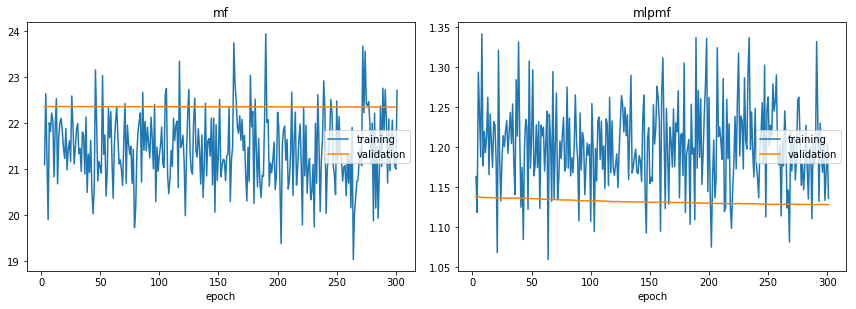

mf:
training   (min:   19.031, max:   23.935, cur:   22.707)
validation (min:   22.343, max:   22.354, cur:   22.343)

mlpmf:
training   (min:    1.060, max:    1.342, cur:    1.136)
validation (min:    1.128, max:    1.138, cur:    1.128)


KeyboardInterrupt: 

In [208]:
for epoch in range(3):
    mftrain,mlptrain, = epoch_run_2(MF_model,MLP_model, train_generator, testab, MF_opt, MLP_opt,MF_criterion,MLP_criterion)
    torch.save(MF_model.state_dict(), './models/mf_1.pkl')
    torch.save(MLP_model.state_dict(), './models/mfmlp_2.pkl')

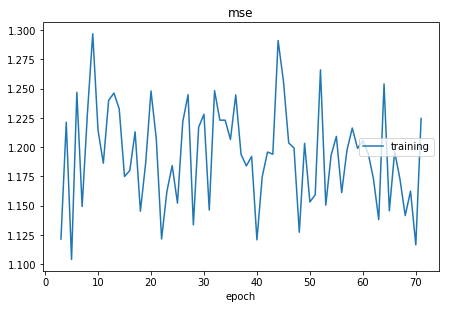

mse:
training   (min:    1.104, max:    1.297, cur:    1.224)


RuntimeError: index out of range at ..\aten\src\TH/generic/THTensorEvenMoreMath.cpp:193

In [213]:
train_mse = 0
val_mse = 0
for epoch in range(EPOCH):
    print("epoch: ", epoch)
    train_mse = epoch_run(MLP_model, train_generator, MLP_opt, MLP_criterion,"train",True)
    val_mse = epoch_run(MLP_model, test_generator, MLP_opt, MLP_criterion, "val")
    loss_.append(train_mse)
    loss_t.append(val_mse)
    if epoch%5 ==0:
        torch.save(MLP_model.state_dict(), './models/mfmlp_10.pkl')
    print("train loss: ", train_mse)
    print("val loss: ", val_mse)

In [185]:
user_item_pairs_test

array([[1.8000e+01, 6.5900e+02],
       [1.8000e+01, 1.1360e+03],
       [1.8000e+01, 1.2210e+03],
       ...,
       [7.0169e+04, 1.9020e+03],
       [7.0215e+04, 2.8090e+03],
       [7.0233e+04, 3.8640e+03]])

In [176]:
num_users

70268

In [177]:
len(a[a[:,1]==-2147483648,0])

0

In [178]:
# emb = torch.nn.Embedding(num_embeddings=num_users, embedding_dim=8,sparse=True)
# a  = torch.tensor(a).type(torch.long).to(device)
# emb(a)

In [179]:
a[a<=0]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [180]:
num_users

70268

In [19]:
# ll = None
# for local_batch, local_labels  in train_generator:
# #     print(local_batch)
# #     print(local_batch[:,0])
# #     print(local_batch[:,1])
# #     print(local_batch[:,2])
#     ll = local_batch
#     y_preds = model(local_batch[:,0], local_batch[:,1])
#     print(y_preds)

In [20]:
# ll[:,1].shape

In [171]:
val_mse = epoch_run(model, test_generator, opt, criterion, "val")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [172]:
val_mse

1.1722545409902476

In [170]:
# eps = len(loss_)
# # MSE plot
# fig2, ax2 = plt.subplots()
# ax3 = ax2.twinx()
# lns2 = ax2.plot(np.arange(eps), loss_, label="Loss")
# lns3 = ax3.plot(np.arange(eps), loss_t, label="Loss")

# ax2.set_xlabel('iteration')
# ax2.set_ylabel('training mse')
# ax3.set_ylabel('val mse')
# lns = lns3 + lns2
# labels = ["train mse", "val mse"]
# plt.legend(lns, labels, loc=7)

# plt.show()

In [207]:
evaluate(model,test_generator)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[[3.5088584 2.4691691 2.6627598 ... 3.7977843 3.4851832 2.7138577]
 [3.        3.        2.        ... 3.        3.        3.       ]]


1.1338468574501952

In [206]:
# 保存
torch.save(model.state_dict(), './models/mfmlp.pkl')


In [202]:
# 加载
model.load_state_dict(torch.load('./models/mfmlp.pkl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [162]:
model

MLP(
  (embedding_user): Embedding(131099, 8)
  (embedding_item): Embedding(4500, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
)

In [208]:
prd, lab = predict(model,test_generator)
prd = prd.to("cpu").numpy()
lab = lab.to("cpu").numpy()
prd = np.around(prd[:,0],0)
lab = np.around(lab[:,0],0)
print("prd:",prd,"lab:",lab)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


prd: [4. 4. 4. ... 4. 4. 4.] lab: [4. 3. 3. ... 3. 3. 3.]


In [209]:
prd[prd<=2]=0
prd[prd>2]=1
lab[lab<=2]=0
lab[lab>2]=1

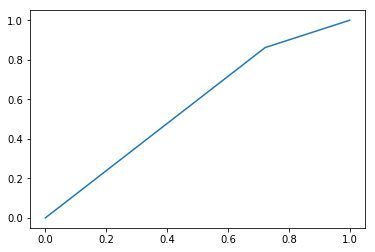

In [210]:
fpr,tpr,threshold = roc_curve(list(prd), list(lab))
plt.plot(fpr,tpr)
plt.show()

In [211]:
auc(fpr,tpr)

0.5697199984884289

In [196]:
# liveplot = PlotLosses()

# for i in range(10):
#     liveplot.update({
#         'accuracy': 1 - np.random.rand() / (i + 2.),
#         'val_accuracy': 1 - np.random.rand() / (i + 0.5),
        
#         'mse': 1. / (i + 2.),
#         'val_mse': 1. / (i + 0.5)
#     })
#     liveplot.draw()